In [2]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt

In [15]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 14,           # Font size for text
    'axes.titlesize': 16,      # Font size for axes titles
    'axes.labelsize': 14,      # Font size for x and y labels
    'xtick.labelsize': 14,     # Font size for x tick labels
    'ytick.labelsize': 14,     # Font size for y tick labels
    'legend.fontsize': 14,     # Font size for legend text
    'figure.figsize': (20, 12), # Default figure size
})

In [3]:
# Open files

gkvInputCatv02_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/gkvInputCatv02/gkvInputCatv02.fits')[1].data
# SpecObjMerged_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/gkvInput-SpectObj27/SpectObjgkvInputMerged.fits')[1].data
SpecObjMerged_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

gkvInputCatv02_rows = len(gkvInputCatv02_raw)
SpecObjMerged_rows = len(SpecObjMerged_raw)

print(f'gkvInputCatv02 file is opened and it has {gkvInputCatv02_rows} objects')
print(f'SpecObjMerged_raw file is opened and it has {SpecObjMerged_rows} objects')

gkvInputCatv02 file is opened and it has 18193252 objects
SpecObjMerged_raw file is opened and it has 370116 objects


In [3]:
#gkvInput
'''
    All classes were encoded numerically in the following way:
        0 = not visually inspected (eyeclass only)
        1 = galaxy
        2 = star
        3 = ambiguous
        4 = artefact
        5 = blended (eyeclass and uberclass only)
        6 = fragment (eyeclass and uberclass only)
    '''

'\n    All classes were encoded numerically in the following way:\n        0 = not visually inspected (eyeclass only)\n        1 = galaxy\n        2 = star\n        3 = ambiguous\n        4 = artefact\n        5 = blended (eyeclass and uberclass only)\n        6 = fragment (eyeclass and uberclass only)\n    '

In [4]:
#SpecCat
'''
    The parameter SURVEY_CODE is a numerical representation of SURVEY:
       Originating survey   Code
       -------------------------
       SDSS                  1
       2dFGRS                2
       MGC                   3
       2SLAQ-LRG             4
       GAMA                  5
       6dFGS                 6
       UZC                   7
       2QZ                   8
       2SLAQ-QSO             9
       NED                  10
       GAMA_LT              11
       WiggleZ              12
       VVDS                 13
'''

'\n    The parameter SURVEY_CODE is a numerical representation of SURVEY:\n       Originating survey   Code\n       -------------------------\n       SDSS                  1\n       2dFGRS                2\n       MGC                   3\n       2SLAQ-LRG             4\n       GAMA                  5\n       6dFGS                 6\n       UZC                   7\n       2QZ                   8\n       2SLAQ-QSO             9\n       NED                  10\n       GAMA_LT              11\n       WiggleZ              12\n       VVDS                 13\n'

In [4]:
# gkv masks
gkv_masks = (
         (gkvInputCatv02_raw['uberclass'] == 1 ) & #galaxy
         (gkvInputCatv02_raw['duplicate'] == False) &
         (gkvInputCatv02_raw['mask'] == False) &
         (gkvInputCatv02_raw['starmask'] == False)  #objects near bright stars
)

gkvInputCatv02 = gkvInputCatv02_raw[gkv_masks]
print('gkvInputCatv02, number of objects without a mask:',len(gkvInputCatv02))

gkvInputCatv02, number of objects without a mask: 7333170


In [5]:
# spec masks
spec_masks = (
         (SpecObjMerged_raw['duplicate'] == False) &
         (SpecObjMerged_raw['mask'] == False) &
         (SpecObjMerged_raw['starmask'] == False) &
         (SpecObjMerged_raw['uberclass'] == 1)        #for gkvscience
)
SpecObjMerged = SpecObjMerged_raw[spec_masks]
print('SpecObjMerged, number of objects without a mask:',len(SpecObjMerged))

SpecObjMerged, number of objects without a mask: 237284


In [6]:
# magnitude intervals
deltaMag = 0.05
magnitude_intervals = np.arange(14, 24, deltaMag)

In [7]:
regions_of_sky = {
    'G09': {'RAcen': (129.0, 141.0), 'DECcen': (-2.0, 3.0)},
    'G12': {'RAcen': (174.0, 176.0), 'DECcen': (-3.0, 2.0)},
    'G15': {'RAcen': (211.5, 223.5), 'DECcen': (-2.0, 3.0)},
    'G23': {'RAcen': (339.0, 351.0), 'DECcen': (-35.0, -30.0)},
}

In [8]:
#all the functions go here

def get_completeness_by_region(big_survey, small_survey, flux_type, regions):
    completeness_by_region = {}
    for region_name, region in regions.items():
        big_survey_region = filter_objects_by_region(big_survey, region)
        small_survey_region = filter_objects_by_region(small_survey, region)
        counts_of_big_survey = get_interval_counts_from_surveys(survey_name=big_survey_region , flux_type=flux_type)
        counts_of_small_survey = get_interval_counts_from_surveys(survey_name=small_survey_region , flux_type=flux_type)
        completeness = calculate_ratio_between_surveys(counts_small_survey=counts_of_small_survey,counts_big_survey=counts_of_big_survey)
        completeness_by_region[region_name] = completeness
    return completeness_by_region

def get_stat(big_survey, small_survey, flux_type, regions):
    countBigByRegion = {}
    countSmallByRegion = {}
    for region_name, region in regions.items():
        big_survey_region = filter_objects_by_region(big_survey, region)
        small_survey_region = filter_objects_by_region(small_survey, region)
        counts_of_big_survey = get_interval_counts_from_surveys(survey_name=big_survey_region , flux_type=flux_type)
        counts_of_small_survey = get_interval_counts_from_surveys(survey_name=small_survey_region , flux_type=flux_type)
        countBigByRegion[region_name] = counts_of_big_survey
        countSmallByRegion[region_name] = counts_of_small_survey
    return countBigByRegion, countSmallByRegion

def get_interval_counts_from_surveys(survey_name, flux_type):
    flux_list = read_flux(survey_name,flux_type)
    apparent_magnitude = calculate_apparent_magnitude(flux_list)
    interval_counts = count_objects_in_magnitude_intervals(apparent_magnitude, magnitude_intervals)
    return interval_counts


#fuction for reading the fluxes
def read_flux(survey_name, flux_type):
    return survey_name[flux_type]

#fucntion for apparent magnitude
def calculate_apparent_magnitude(flux_data):
    ap_mag_rt = 8.9 - 2.5 * np.log10(flux_data)
    return ap_mag_rt

#function to count the objects in each interval
def count_objects_in_magnitude_intervals(ap_mag_data, intervals):
    counts = np.histogram(ap_mag_data, bins=intervals)[0]
    return counts

# function to find the number of objects in each interval
def count_objects_in_magnitude_intervals(ap_mag_data, intervals):
    counts = np.histogram(ap_mag_data, bins=intervals)[0]
    return counts

# function for the regions in the sky
def filter_objects_by_region(survey_name, region):
    RAcen_mask = (survey_name['RAcen'] >= region['RAcen'][0]) & (survey_name['RAcen'] <= region['RAcen'][1])
    DECcen_mask = (survey_name['DECcen'] >= region['DECcen'][0]) & (survey_name['DECcen'] <= region['DECcen'][1])
    return survey_name[RAcen_mask & DECcen_mask]

def calculate_ratio_between_surveys(counts_small_survey, counts_big_survey):
    ratio = (counts_small_survey / counts_big_survey) * 100
    return ratio


In [9]:
completeness_by_region = get_completeness_by_region(gkvInputCatv02, SpecObjMerged, 'flux_rt', regions_of_sky)
countBigByRegion, countSmallByRegion = get_stat(gkvInputCatv02, SpecObjMerged, 'flux_rt', regions_of_sky)

/tmp/ipykernel_140658/641427263.py:39: RuntimeWarning: invalid value encountered in log10
  ap_mag_rt = 8.9 - 2.5 * np.log10(flux_data)
/tmp/ipykernel_140658/641427263.py:59: RuntimeWarning: invalid value encountered in divide
  ratio = (counts_small_survey / counts_big_survey) * 100


In [11]:
#?plt.step

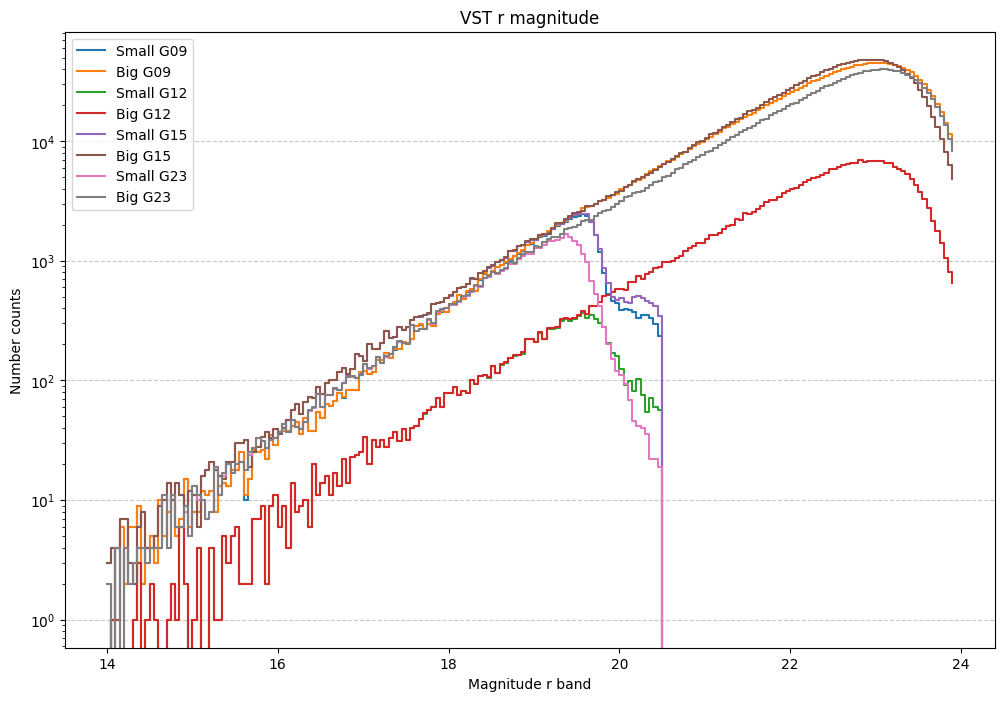

In [12]:
plt.figure(figsize=(12, 8))
for region_name in regions_of_sky:
    plt.step(magnitude_intervals[:-1], countSmallByRegion[region_name], label='Small '+region_name, where='post')#, marker='o', linestyle='None')
    plt.step(magnitude_intervals[:-1], countBigByRegion[region_name], label='Big '+region_name, where='post')#, marker='x', linestyle='None')

plt.xlabel('Magnitude r band')
plt.ylabel('Number counts')
plt.title('VST r magnitude')
plt.yscale('log')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_140658/2123534991.py:4: RuntimeWarning: invalid value encountered in divide
  plt.step(magnitude_intervals[:-1], countSmallByRegion[region_name]/countBigByRegion[region_name], label=region_name, where='post')#, marker='o', linestyle='None')


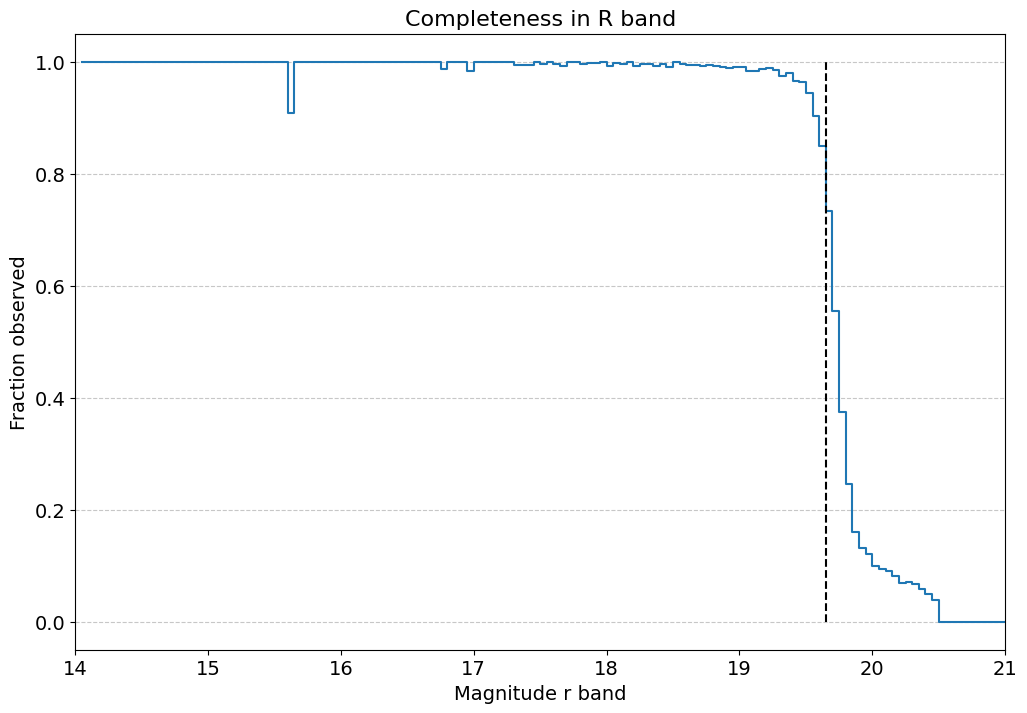

In [17]:
plt.figure(figsize=(12, 8))
#for region_name in regions_of_sky:
region_name = 'G09'
plt.step(magnitude_intervals[:-1], countSmallByRegion[region_name]/countBigByRegion[region_name], label=region_name, where='post')#, marker='o', linestyle='None')
    #plt.step(magnitude_intervals[:-1], np.cumsum(countSmallByRegion[region_name])/np.cumsum(countBigByRegion[region_name]), label='cumulative'+region_name, where='post')# marker='o', linestyle='None')

plt.xlabel('Magnitude r band')
plt.ylabel('Fraction observed')
plt.title('Completeness in R band')
plt.xlim((14, 21))
plt.vlines(19.65, ymin=0, ymax=1, colors='k', linestyles='--')
#plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../erosita_DR1/plots/completeness.png')
plt.show()

In [14]:
np.cumsum(countSmallByRegion[region_name])

array([    2,     2,     6,     6,    10,    12,    15,    19,    23,
          26,    30,    34,    38,    49,    53,    64,    70,    76,
          84,    89,   102,   112,   122,   129,   137,   156,   167,
         183,   203,   220,   240,   261,   279,   303,   330,   363,
         394,   421,   453,   486,   523,   566,   603,   650,   691,
         730,   775,   831,   890,   967,  1027,  1102,  1177,  1262,
        1345,  1440,  1547,  1653,  1757,  1868,  2004,  2129,  2261,
        2419,  2559,  2716,  2882,  3073,  3282,  3486,  3686,  3977,
        4234,  4501,  4768,  5090,  5388,  5760,  6151,  6551,  6976,
        7403,  7855,  8354,  8864,  9417, 10033, 10635, 11347, 12086,
       12888, 13666, 14490, 15346, 16293, 17238, 18268, 19366, 20505,
       21656, 22934, 24208, 25573, 27044, 28521, 30006, 31571, 33234,
       34817, 36293, 37650, 38786, 39757, 40441, 40972, 41392, 41670,
       41870, 42022, 42143, 42253, 42346, 42415, 42461, 42503, 42543,
       42579, 42601,

In [15]:
print(completeness_by_region)
for region,completeness in completeness_by_region.items():
    print(f'For region {region}: minimum is {min(completeness)} and maximum is {max(completeness)}')

{'G09': array([         nan, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
        90.90909091, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        ,  98.63013699,
       100.        , 100.        , 100.        ,  98.29059829,
       100.        , 100.        , 100.        

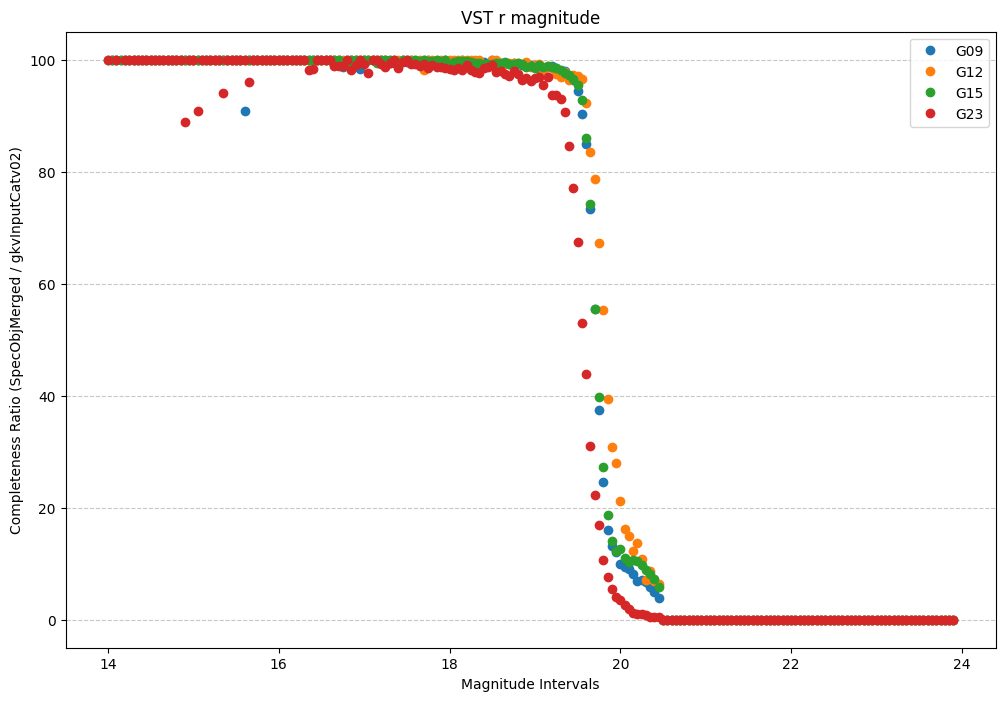

In [16]:
plt.figure(figsize=(12, 8))
for region_name, completeness in completeness_by_region.items():
    #plt.plot(magnitude_intervals[:-1], completeness, label=region_name)
    plt.plot(magnitude_intervals[:-1], completeness, label=region_name, marker='o', linestyle='None')

plt.xlabel('Magnitude Intervals')
plt.ylabel('Completeness Ratio (SpecObjMerged / gkvInputCatv02)')
plt.title('VST r magnitude')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_26623/641427263.py:39: RuntimeWarning: invalid value encountered in log10
  ap_mag_rt = 8.9 - 2.5 * np.log10(flux_data)
/tmp/ipykernel_26623/641427263.py:59: RuntimeWarning: invalid value encountered in divide
  ratio = (counts_small_survey / counts_big_survey) * 100


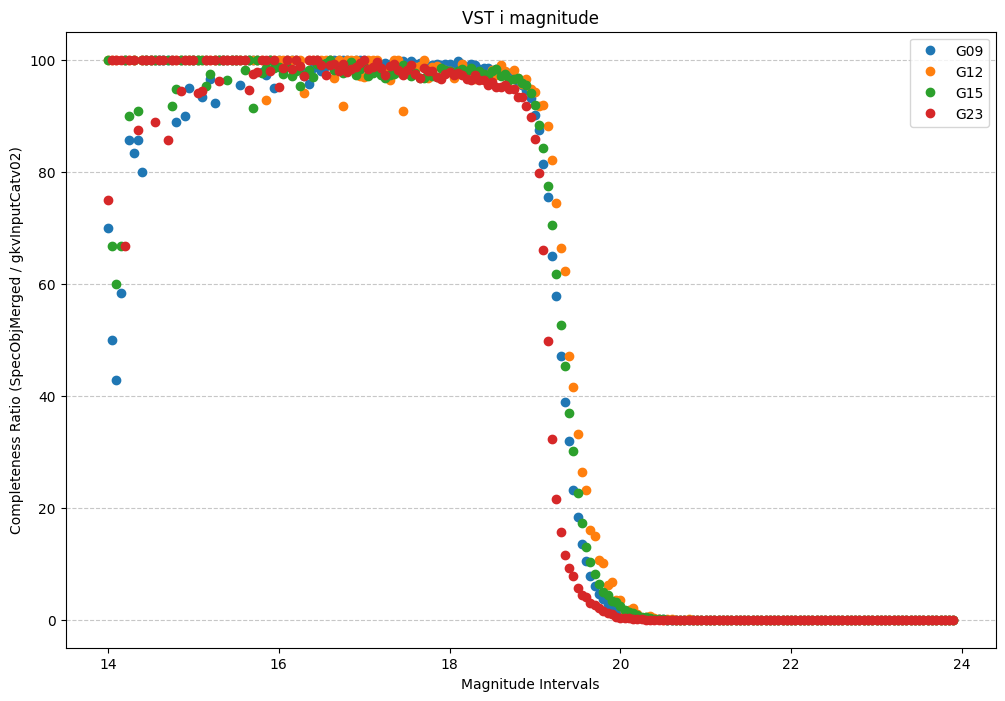

In [17]:
completeness_by_region = get_completeness_by_region(gkvInputCatv02, SpecObjMerged, 'flux_it', regions_of_sky)

plt.figure(figsize=(12, 8))
for region_name, completeness in completeness_by_region.items():
    #plt.plot(magnitude_intervals[:-1], completeness, label=region_name)
    plt.plot(magnitude_intervals[:-1], completeness, label=region_name, marker='o', linestyle='None')


plt.xlabel('Magnitude Intervals')
plt.ylabel('Completeness Ratio (SpecObjMerged / gkvInputCatv02)')
plt.title('VST i magnitude')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipykernel_26623/641427263.py:39: RuntimeWarning: invalid value encountered in log10
  ap_mag_rt = 8.9 - 2.5 * np.log10(flux_data)
/tmp/ipykernel_26623/641427263.py:59: RuntimeWarning: invalid value encountered in divide
  ratio = (counts_small_survey / counts_big_survey) * 100


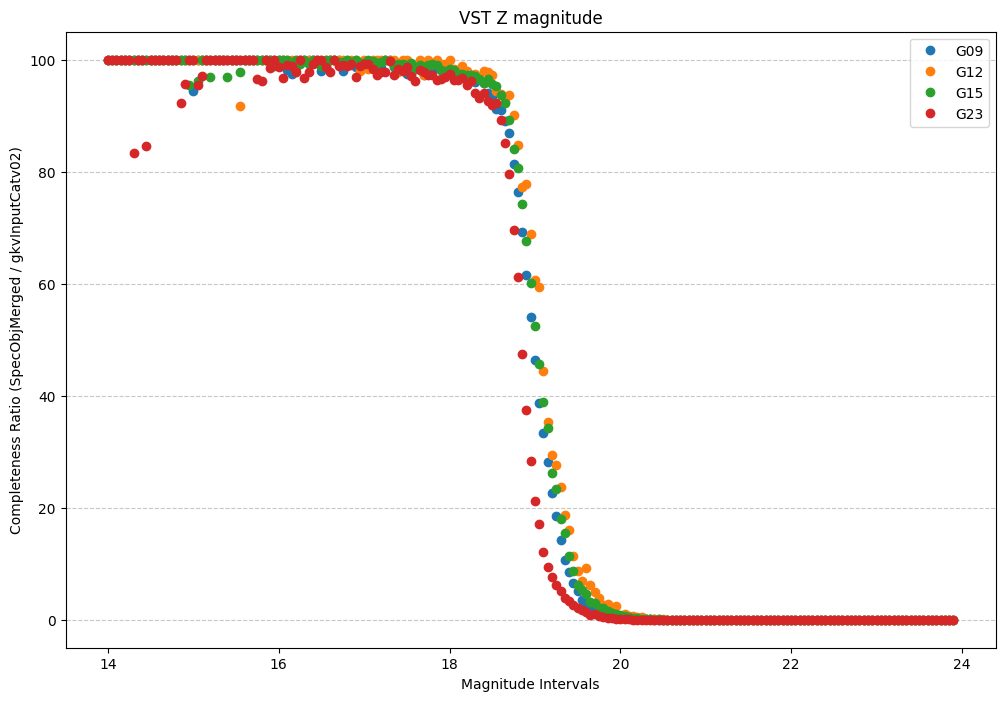

In [18]:
completeness_by_region = get_completeness_by_region(gkvInputCatv02, SpecObjMerged, 'flux_Zt', regions_of_sky)

plt.figure(figsize=(12, 8))
for region_name, completeness in completeness_by_region.items():
    #plt.plot(magnitude_intervals[:-1], completeness, label=region_name)
    plt.plot(magnitude_intervals[:-1], completeness, label=region_name, marker='o', linestyle='None')


plt.xlabel('Magnitude Intervals')
plt.ylabel('Completeness Ratio (SpecObjMerged / gkvInputCatv02)')
plt.title('VST Z magnitude')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()